Notebook para verificar si hay diferencias significativas entre las medias de ADR entre los principales Estados de origen de los clientes

*Importar las librerías*


In [1]:
import pandas as pd 

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, levene

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Cargar los dataset (Ocupaciones completo)

In [2]:
ocupaciones = pd.read_csv("../data/ia_ocupaciones_gigante_limpia2.csv").sort_values(
    "Fecha_hoy",
    ascending=True,
)
print(ocupaciones.shape)
ocupaciones.head()


(2114464, 17)


,Fecha_hoy,ID_Entidad_Fed,ID_Tipo_Habitacion,ID_canal,ID_edificio,ID_Segmento_Mercado,ID_Segmento_Alterno,ID_Segmento_Comp,moneda_cve,ID_empresa,ID_Empresa2,ing_hab,cto_noc,ADR,num_men,num_adu,TREVPEC
663394,2020-11-01,Otro,6,2,2.0,1.0,Otro,Otro,1.0,1.0,1.0,10511.590000,5.0,2102.318000,5.0,11.0,955.599091
663101,2020-11-01,173,Otro,3,2.0,6.0,17.0,34.0,2.0,1.0,1.0,4256.097675,1.0,4256.097675,3.0,2.0,45491.300000
663102,2020-11-01,173,6,3,2.0,6.0,17.0,34.0,2.0,1.0,1.0,1210.721804,1.0,1210.721804,1.0,2.0,12940.800000
663103,2020-11-01,173,17,3,3.0,6.0,15.0,32.0,1.0,1.0,7.0,1890.750000,1.0,1890.750000,0.0,2.0,945.375000
663104,2020-11-01,173,17,3,3.0,6.0,17.0,34.0,1.0,1.0,7.0,2055.020000,1.0,2055.020000,0.0,2.0,1027.510000


In [3]:
nombreestados=pd.read_csv("../data/iar_entidadfed.csv")

# Encontrar si hay diferencia significativa

Entre la media de TREVPEC por estado de origen de los clientes:

---




## 1. Calcular las medias


In [4]:
# Remover todos los registros donde no hay ingresos o ingresos menor a 1 peso, dado que esto puede afectar la transformación logarítmica
ocupaciones=ocupaciones[ocupaciones['cto_noc'] !=0 ]
ocupaciones=ocupaciones[ocupaciones['ing_hab'] !=0 ]
ocupaciones=ocupaciones[ocupaciones['ing_hab'] >1 ]
print(ocupaciones.shape)
topomeanADR=ocupaciones.groupby('ID_Entidad_Fed')['TREVPEC'].mean().reset_index()
topcuenta=ocupaciones.groupby('ID_Entidad_Fed')["Fecha_hoy"].count()
topcuenta.rename('Count', inplace=True) 

merged_df = pd.merge(topomeanADR, topcuenta, on='ID_Entidad_Fed', how='inner')
merged_df.sort_values(by='Count', ascending=False, inplace=True)
merged_df['Proporcion'] = round(merged_df['Count'] / merged_df['Count'].sum(),2)*100
merged_df

(1056041, 17)


,ID_Entidad_Fed,TREVPEC,Count,Proporcion
5,Otro,16610.858874,546696,52.0
0,173,12046.764446,241343,23.0
2,294,19301.584876,82096,8.0
3,48,15648.270076,81175,8.0
4,5,13953.287377,60661,6.0
1,253,16573.033826,44070,4.0


In [46]:
nombreestados['ID_Entidad_Fed']=nombreestados['ID_Entidad_Fed'].astype(str)
merged_df2 = pd.merge(merged_df, nombreestados, on='ID_Entidad_Fed', how='left')
merged_df3=merged_df2[['ID_Entidad_Fed', 'Estado_Nombre', 'TREVPEC', 'Count', 'Proporcion']]
merged_df3.head(6)

,ID_Entidad_Fed,Estado_Nombre,TREVPEC,Count,Proporcion
0,Otro,NaN,16610.858874,546696,52.0
1,173,JALISCO,12046.764446,241343,23.0
2,294,QUINTANA ROO,19301.584876,82096,8.0
3,48,CALIFORNIA,15648.270076,81175,8.0
4,5,AGUASCALIENTES,13953.287377,60661,6.0
5,253,NUEVO LEÓN,16573.033826,44070,4.0


De acuerdo con el groupby, parece ser que la media de gasto por cliente es diferente entre los distintos estados (o países), habrá que hacer una prueba ANOVA para comprobar este supuesto

In [6]:
# Datos normalmente distribuidos
normal_data = np.random.normal(loc=0, scale=1, size=100)

# Datos no normales
non_normal_data = np.random.exponential(scale=1, size=100)

# Prueba de Shapiro
print("Normal:")
print(shapiro(normal_data))

print("No Normal:")
print(shapiro(non_normal_data))

Normal:
ShapiroResult(statistic=np.float64(0.9919708520992161), pvalue=np.float64(0.8191099634799734))
No Normal:
ShapiroResult(statistic=np.float64(0.8024022826906491), pvalue=np.float64(2.9363126730240197e-10))


In [13]:
from scipy.stats import anderson
import numpy as np

# Supongamos que tienes un conjunto de datos
data = np.random.normal(loc=0, scale=1, size=100)


# Prueba de Anderson-Darling
result = anderson(data, dist='norm')  # 'norm' es la distribución normal

print("Estadístico A²:", result.statistic)
print("Valores críticos:", result.critical_values)
print("Niveles de significancia:", result.significance_level)

# Interpretación (por ejemplo, con nivel de significancia del 5%)
if result.statistic > result.critical_values[2]:  # índice 2 corresponde a 5%
    print("Se rechaza H₀: los datos NO provienen de una distribución normal.")
else:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")

Estadístico A²: 0.3622944738229137
Valores críticos: [0.555 0.632 0.759 0.885 1.053]
Niveles de significancia: [15.  10.   5.   2.5  1. ]
No se rechaza H₀: los datos podrían provenir de una distribución normal.


## 2. Realizar el análsis anova

In [41]:
df_Anova = ocupaciones[['ID_Entidad_Fed','TREVPEC']]
df_Anova = df_Anova[df_Anova['ID_Entidad_Fed'] != 'Otro']


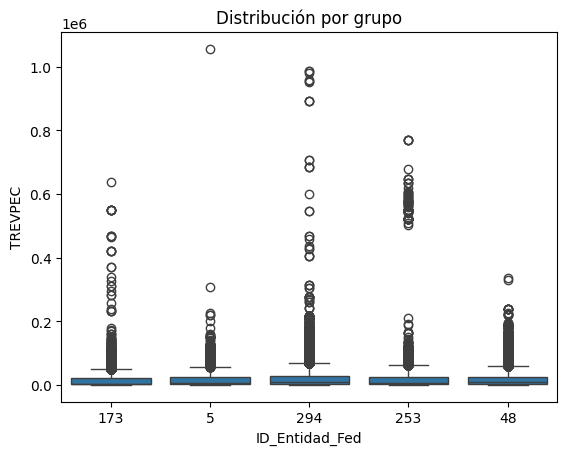

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='ID_Entidad_Fed', y='TREVPEC', data=df_Anova)
plt.title("Distribución por grupo")
plt.show()

Se encuentra que muy probablemente la distribución de los datos no sea normal, quizá alguna transformación logre acercarlos para así cumplir los supuestos

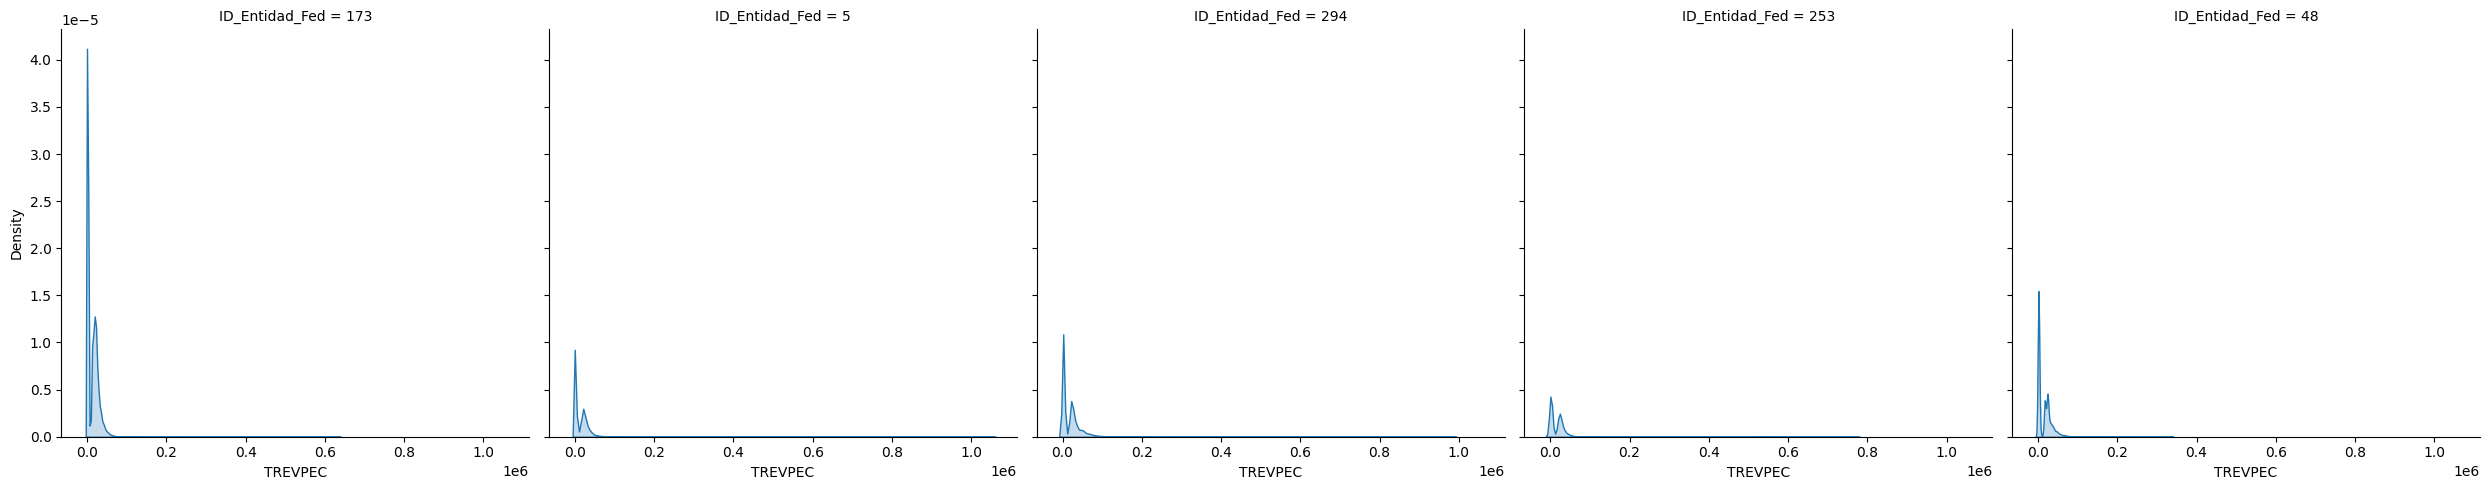

In [40]:
# Muestra la distribución de cada grupo
sns.displot(df_Anova, x='TREVPEC', col='ID_Entidad_Fed', kind='kde', fill=True)

Al ver las gráficas de las distribuciones es muy probable que se traten de distrinbuciones bimodales, por lo que las transformaciones no lograrían que pasen pruebas de normalidad, por lo que, se utilizará una prueba análoga al ANOVA que no requiera cumplir el supuesto de normalidad: test de Kruskal-Wallis.

### Test de Kruskal-Wallis: prueba no paramétrica

Hipótesis:
- $H_0$ (Hipótesis nula): Las medias de ocupación entre los estados seleccionados son iguales.

- $H_1$ (Hipótesis alternativa): Al menos un estado tiene una media de ocupación diferente.

In [43]:
from scipy.stats import kruskal
kruskal(
    df_Anova[df_Anova['ID_Entidad_Fed'] == '173']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '294']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '48']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '5']['TREVPEC'],
    df_Anova[df_Anova['ID_Entidad_Fed'] == '253']['TREVPEC']
)

KruskalResult(statistic=np.float64(14590.02212156331), pvalue=np.float64(0.0))

**No se rechaza la hipótesis nula. Se encuentra que la media es significativamente diferente con un $a$=0.05**

---

### Test de Dunn: prueba no paramétrica post hoc

Hipótesis:
- $H_0$ (Hipótesis nula): Las medias de ocupación entre los estados seleccionados son iguales.

- $H_1$ (Hipótesis alternativa): La media entre estados A, B es diferente.

In [45]:
import scikit_posthocs as sp
sp.posthoc_dunn(df_Anova, val_col='TREVPEC', group_col='ID_Entidad_Fed', p_adjust='bonferroni')

,173,253,294,48,5
173,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.712910e-298
253,0.000000e+00,1.000000e+00,8.130288e-62,1.586163e-26,4.764384e-154
294,0.000000e+00,8.130288e-62,1.000000e+00,3.840996e-237,0.000000e+00
48,0.000000e+00,1.586163e-26,3.840996e-237,1.000000e+00,4.305560e-79
5,6.712910e-298,4.764384e-154,0.000000e+00,4.305560e-79,1.000000e+00


**Con un $a$=0.05, se rechaza la hipótesis nula para 5 con 173, 253 y 48; así como 253 con 294 y 48; 48 con 294. Lo que representa que la media es significativamente diferente entre esos estados**

# Mostrar la tendencia anual de los distintos grupos

In [13]:

subset_df = ocupaciones[ocupaciones['ID_Entidad_Fed'].isin(merged_df['ID_Entidad_Fed'].tail(5))]


In [16]:
## Add the column of month to the DataFrame
subset_df['Fecha_hoy'] = pd.to_datetime(subset_df['Fecha_hoy'])
subset_df['month'] = subset_df['Fecha_hoy'].dt.month
subset_df['year'] = subset_df['Fecha_hoy'].dt.year
# Group by month and year, and calculate the mean of ADR
monthly_mean_adr = subset_df.groupby(['year', 'month', 'ID_Entidad_Fed'])['TREVPEC'].mean().reset_index()

C:\Users\angel\AppData\Local\Temp\ipykernel_6596\3374057481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Fecha_hoy'] = pd.to_datetime(subset_df['Fecha_hoy'])
C:\Users\angel\AppData\Local\Temp\ipykernel_6596\3374057481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['month'] = subset_df['Fecha_hoy'].dt.month
C:\Users\angel\AppData\Local\Temp\ipykernel_6596\3374057481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

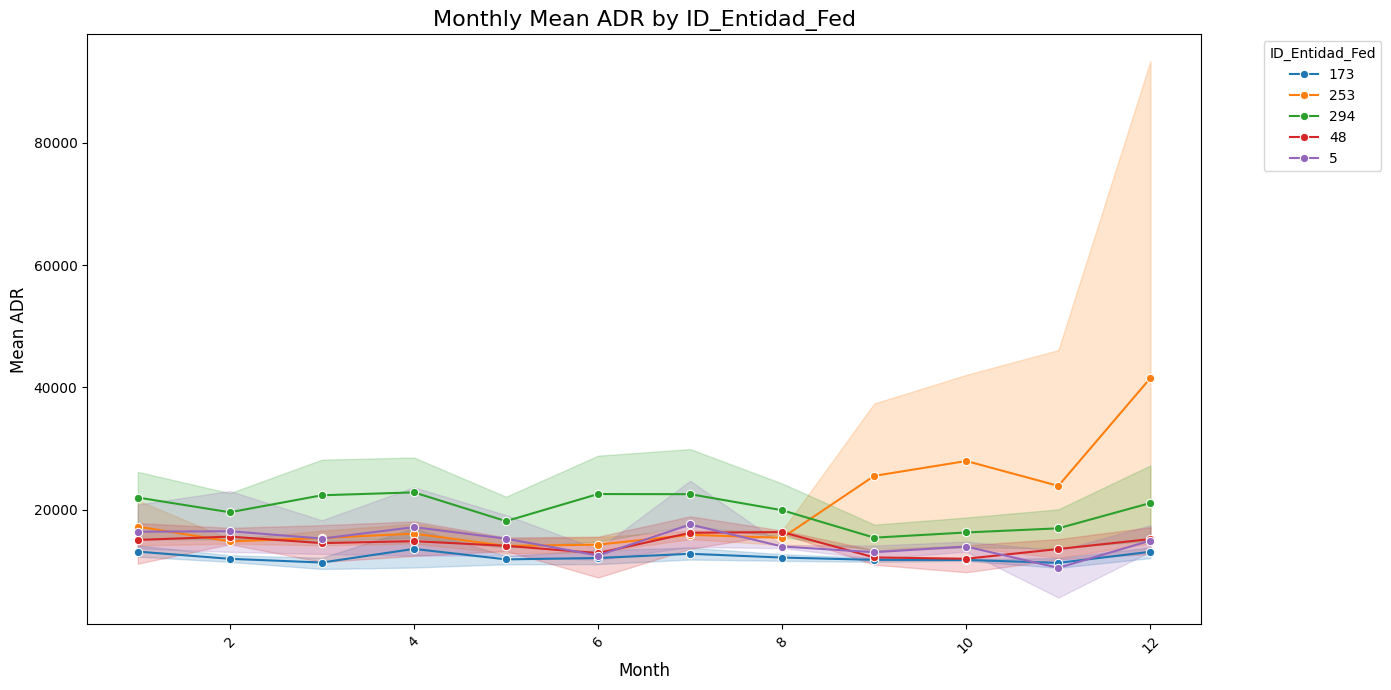

In [17]:
# Graph the monthly mean ADR for each ID_Entidad_Fed
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_mean_adr, x='month', y='TREVPEC', hue='ID_Entidad_Fed', marker='o')
plt.title('Monthly Mean ADR by ID_Entidad_Fed', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean ADR', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='ID_Entidad_Fed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

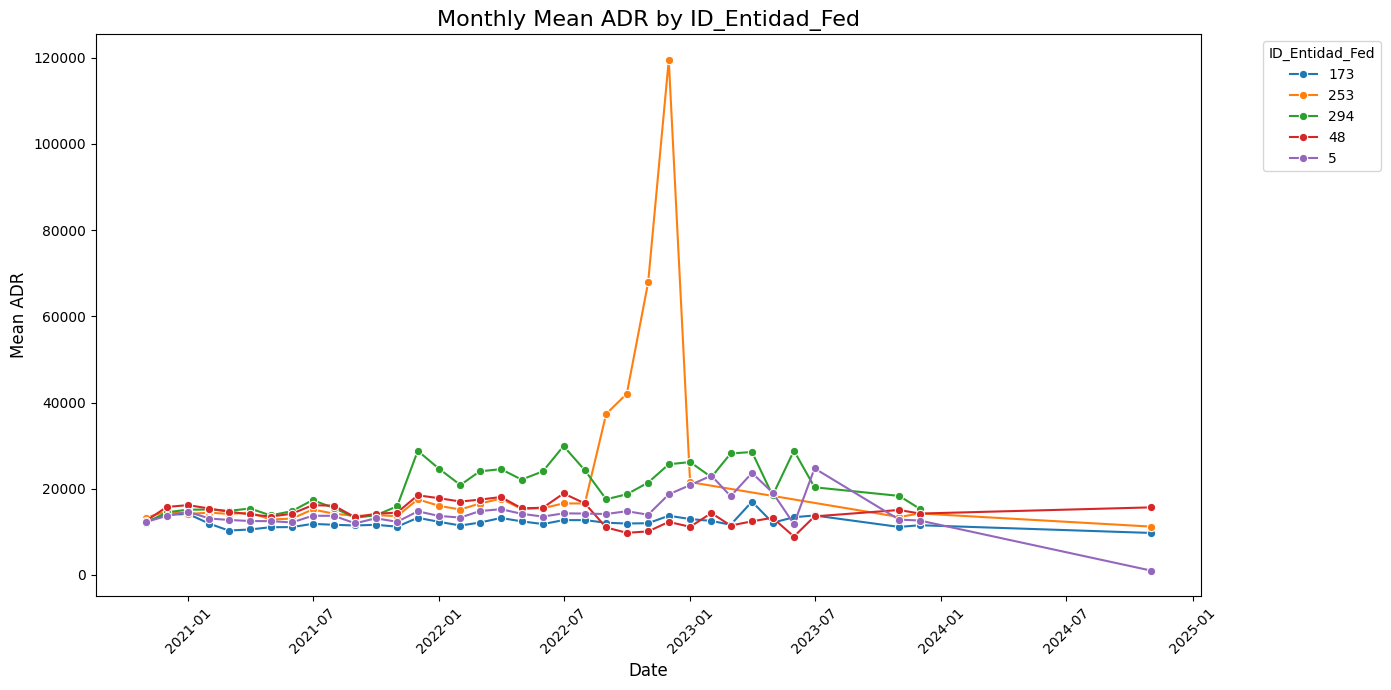

In [18]:
# The same plot, but with year and month as a single datetime column
monthly_mean_adr['date'] = pd.to_datetime(monthly_mean_adr[['year', 'month']].assign(day=1))
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_mean_adr, x='date', y='TREVPEC', hue='ID_Entidad_Fed', marker='o')
plt.title('Monthly Mean ADR by ID_Entidad_Fed', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean ADR', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='ID_Entidad_Fed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Checar datos atípicos, en especial diciembre 2022